## Genetic Algorithm for Feature Selection

Dataset = https://www.kaggle.com/andrewmvd/heart-failure-clinical-data


Lets do some eda first

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from genetic_selection import GeneticSelectionCV
from featureFinder import find
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score
import numpy as np
from feature_selection_ga import FeatureSelectionGA, FitnessFunction
import pickle
import math
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [3]:

df = pd.read_csv("data/heart_failure_clinical_records_dataset.csv")
total_feats = list(df.columns)


total_feats

['age',
 'anaemia',
 'creatinine_phosphokinase',
 'diabetes',
 'ejection_fraction',
 'high_blood_pressure',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'sex',
 'smoking',
 'time',
 'DEATH_EVENT']

So these are our total features, what we need now is to find out the features are most important for predictions. 

The "DEATH_EVENT" feature here is our target variable. 

In [4]:
total_feats = total_feats[:-1]
target = df.columns[-1]

catcols = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]
# for c in catcols:
#   D[c] = D[c].astype("category")
numcols = set(total_feats) - set(catcols)
numcols = list(numcols)

Out of all "total_feats", there are several numerical features(numcols) and several categorical features(catcols). Now we will apply Min Max Scaling on the numerical features to make it standardised

In [6]:
for col in numcols: 
  scaler = MinMaxScaler()
  df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))
    
print(df.head())

        age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  0.636364        0                  0.071319         0           0.090909   
1  0.272727        0                  1.000000         0           0.363636   
2  0.454545        0                  0.015693         0           0.090909   
3  0.181818        1                  0.011227         0           0.090909   
4  0.454545        1                  0.017479         1           0.090909   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1   0.290823          0.157303      0.485714    1   
1                    0   0.288833          0.067416      0.657143    1   
2                    0   0.165960          0.089888      0.457143    1   
3                    0   0.224148          0.157303      0.685714    1   
4                    0   0.365984          0.247191      0.085714    0   

   smoking      time  DEATH_EVENT  
0        0  0.000000            1  
1       

### Now we will be trying to find the best features for the model to work on by using Genetic Algorithm.

In [8]:
#set seed for being able to reproduce same random numbers

SEED = 6969
random.seed(SEED)
np.random.seed(SEED)

class GeneticSelector():
    def __init__(self,X, y, estimator, n_gen, size, n_best, n_rand, 
                 n_children, mutation_rate):
        # Estimator
        self.estimator = estimator
        # Number of generations
        self.n_gen = n_gen
        # Number of chromosomes in population
        self.size = size
        # Number of best chromosomes to select
        self.n_best = n_best
        # Number of random chromosomes to select
        self.n_rand = n_rand
        # Number of children created during crossover
        self.n_children = n_children
        # Probablity of chromosome mutation
        self.mutation_rate = mutation_rate
        #Train Set
        self.X = X
        #Lab
        self.y = y
        
        if int((self.n_best + self.n_rand) / 2) * self.n_children != self.size:
            raise ValueError("The population size is not stable.")  
            
    def initilize(self):
        population = []
        for i in range(self.size):
            chromosome = np.ones(self.n_features, dtype=np.bool)
            mask = np.random.rand(len(chromosome)) < 0.3
            chromosome[mask] = False
            population.append(chromosome)
        return population

    def fitness(self, population):
        X, y = self.dataset
        scores = []
        for chromosome in population:

            score = -1.0 * np.mean(cross_val_score(self.estimator, X[:,chromosome], y, 
                                                       cv=5, 
                                                       scoring="neg_mean_squared_error"))
            scores.append(score)
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds]), list(population[inds,:])

    def select(self, population_sorted):
        population_next = []
        for i in range(self.n_best):
            population_next.append(population_sorted[i])
        for i in range(self.n_rand):
            population_next.append(random.choice(population_sorted))
        random.shuffle(population_next)
        return population_next

    def crossover(self, population):
        population_next = []
        for i in range(int(len(population)/2)):
            for j in range(self.n_children):
                chromosome1, chromosome2 = population[i], population[len(population)-1-i]
                child = chromosome1
                mask = np.random.rand(len(child)) > 0.5
                child[mask] = chromosome2[mask]
                population_next.append(child)
        return population_next
	
    def mutate(self, population):
        population_next = []
        for i in range(len(population)):
            chromosome = population[i]
            if random.random() < self.mutation_rate:
                mask = np.random.rand(len(chromosome)) < 0.05
                chromosome[mask] = False
            population_next.append(chromosome)
        return population_next

    def generate(self, population):
        # Selection, crossover and mutation
        scores_sorted, population_sorted = self.fitness(population)
        population = self.select(population_sorted)
        population = self.crossover(population)
        population = self.mutate(population)
        # History
        self.chromosomes_best.append(population_sorted[0])
        self.scores_best.append(scores_sorted[0])
        self.scores_avg.append(np.mean(scores_sorted))

        return population

    def fit(self, X, y):
        print("Fitting")
        self.chromosomes_best = []
        self.scores_best, self.scores_avg  = [], []

        self.dataset = X, y
        self.n_features = X.shape[1]

        population = self.initilize()
        for i in range(self.n_gen):
            population = self.generate(population)

        return self 

    @property
    def support_(self):
        print("Best Chromosomes are::")
        print(self.chromosomes_best[-1])
        return self.chromosomes_best[-1]

    def plot_scores(self):
        plt.plot(self.scores_best, label='Best')
        plt.plot(self.scores_avg, label='Average')
        plt.legend()
        plt.ylabel('Scores')
        plt.xlabel('Generation')
        #plt.show()

In [9]:
def find(df):

    total_features = df.columns
    total_features = df.columns[:-1]
    X = df[total_features[:-1]] 
    y = df['DEATH_EVENT']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4)

    X_train = X_train.values
    y_train = y_train.values

    sel =  GeneticSelector(X, y, estimator=LinearRegression(), 
                      n_gen=7, size=200, n_best=40, n_rand=40, 
                      n_children=5, mutation_rate=0.05)

    sel.fit(X_train, y_train)
    sel.plot_scores()
    featurePrefs = sel.support_
    
    return featurePrefs

Here the find() method returns mask for the features. Thus when we apply the masks to the total_features we will get the important features.

Fitting
Best Chromosomes are::
[ True False False False  True  True False  True  True False False]
['age', 'ejection_fraction', 'high_blood_pressure', 'serum_creatinine', 'serum_sodium']
0.7998084656084656


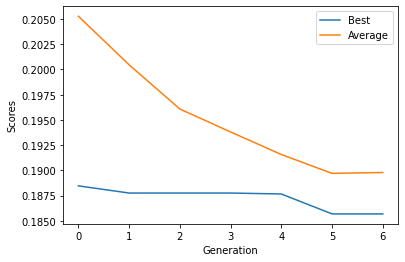

In [10]:
prefs = find(df)

new = []

for i in range(prefs.shape[0]):
    if prefs[i] == True:
        new.append(total_feats[i])

print(new)
X = df[new]

y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state= 46)

clf = RandomForestClassifier(max_depth = 3)
rskf = RepeatedStratifiedKFold(n_repeats = 10, n_splits = 10)
X_prime = df[new]; y_prime = df.iloc[:,-1]
print(np.mean(cross_val_score(clf, X_prime, y_prime, cv = rskf, scoring = "roc_auc")))